In [99]:
import pickle
import numpy as np
from tqdm import tqdm
from collections import defaultdict

import cv2
from matplotlib import pyplot as plt

import stanza
stanza.download('en')
nlp = stanza.Pipeline('en')

# Get labels

In [15]:
# !wget https://raw.githubusercontent.com/shilrley6/Faster-R-CNN-with-model-pretrained-on-Visual-Genome/master/data/genome/1600-400-20/objects_vocab.txt
# Then add background as first label

--2021-04-29 21:43:12--  https://raw.githubusercontent.com/shilrley6/Faster-R-CNN-with-model-pretrained-on-Visual-Genome/master/data/genome/1600-400-20/objects_vocab.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12782 (12K) [text/plain]
Saving to: ‘objects_vocab.txt’

100%[======================================>] 12,782      --.-K/s   in 0s      

2021-04-29 21:43:13 (71.9 MB/s) - ‘objects_vocab.txt’ saved [12782/12782]



In [17]:
cls2name = {ix: t.strip() for ix, t in enumerate(open('objects_vocab.txt').readlines())}

In [78]:
all_obj_names = set()
for n in cls2name.values():
    names = n.split(",")
    for name in names:
        for w in name.split():
            all_obj_names.add(w)
len(all_obj_names), list(all_obj_names)[:10]

(1401,
 ['bench',
  'bear',
  'lock',
  'man',
  'cable',
  'flip',
  'handbag',
  'cuff',
  'electrical',
  'pens'])

In [65]:
list(cls2name.values())[:10]

['__background__',
 'yolk',
 'goal',
 'bathroom',
 'macaroni',
 'umpire',
 'toothpick',
 'alarm clock',
 'ceiling fan',
 'photos']

In [143]:
name2cls = {v: k for k, v in cls2name.items()}

# Noun-labels overlap

In [58]:
import os, sys
sys.path.append("../volta")
from volta.datasets.flickr30ke_ablation_dataset import get_annotations, get_sentence_data

In [60]:
with open("/science/image/nlp-datasets/emanuele/data/flickr30k_entities/val.txt", "r") as f:
    images = f.read().splitlines()

entries = []
for img in images:
    annotation = get_annotations(os.path.join("/science/image/nlp-datasets/emanuele/data/flickr30k_entities/Annotations", img + ".xml"))
    sentences = get_sentence_data(os.path.join("/science/image/nlp-datasets/emanuele/data/flickr30k_entities/Sentences", img + ".txt"))
    for i, sent in enumerate(sentences):
        for phrase in sent["phrases"]:
            if str(phrase["phrase_id"]) in annotation["boxes"].keys():
                entries.append(
                    {
                        "caption": phrase["phrase"],
                        "first_word_index": phrase["first_word_index"],
                        "sent_id": int(phrase["phrase_id"]),
                        "image_id": int(img),
                        "refBoxes": annotation["boxes"][str(phrase["phrase_id"])],
                        "sentence": sent["sentence"]
                    }
                )
len(entries)

14433

In [62]:
# get phrases
phrases = [entry['caption'] for entry in entries]
phrases[:3]

['A man', 'a blue hard hat', 'orange safety vest']

In [215]:
# get nouns
nouns = []
num2cnt = defaultdict(int)
for phr in tqdm(phrases):
    doc = nlp(phr)
    phr_nouns = []
    for sent in doc.sentences:
        for word in sent.words:
            if word.upos in {"NOUN", "PROPN"}:
                phr_nouns.append(word.text)
    num2cnt[len(phr_nouns)] += 1
    nouns.append(phr_nouns)
num2cnt

100%|██████████| 14433/14433 [22:51<00:00, 10.52it/s]


defaultdict(int, {1: 12019, 2: 1881, 4: 26, 3: 149, 0: 353, 5: 5})

In [183]:
# num phrases with >= 1 overlap of nouns
num_phrases_with_matching_nouns = 0
for n_list in nouns:
    num_phrases_with_matching_nouns += int(len(set(e.lower() for e in n_list).intersection(all_obj_names)) > 0)
print(num_phrases_with_matching_nouns)

11821

In [133]:
# num phrases with >= 2 overlap of nouns
num_phrases_with_matching_nouns = 0
for n_list in nouns:
    num_phrases_with_matching_nouns += int(len(set(e.lower() for e in n_list).intersection(all_obj_names)) > 1)
print(num_phrases_with_matching_nouns)

945

## Data exact matching

In [327]:
phr2match = dict()
ix2match = dict()
phr2label = dict()
ix2label = dict()
ix = 0
for phr, phr_nouns in tqdm(zip(phrases, nouns)):
    # 1. we take the list of lower-cased NOUNs in a text phrase
    phr_nouns = list(e.lower() for e in phr_nouns)
    matches = []
    labels = []
    for n, li in name2cls.items():
        # 2. for each object label in Faster R-CNN VG
        cls_words = []
        for names in n.split(","):
            # - we take the list of (lower-cased) words in an object label, and
            # - we compute their intersection with nouns in phrases
            cls_words.append([name for name in names.strip().split(" ")])
        cls_overlap = [phr_nouns == c for c in cls_words]
        if np.sum(cls_overlap):
            # 3. if there is an exact match between phrase nouns and label, we add the object label to the list of possible matches
            matches.append(n)
            labels.append(li)
    if len(matches) == 1:
        phr2match[phr] = matches[0]
        ix2match[ix] = matches[0]
        phr2label[phr] = labels[0]
        ix2label[ix] = labels[0]
    ix += 1
len(phr2match), len(ix2match), len(nouns)

14433it [06:13, 38.67it/s]


(3235, 10159, 14433)

In [332]:
ix2match[0], ix2label[0], cls2name[ix2label[0]], phrases[0]

('man', 51, 'man', 'A man')

## Save LabelMatch dataset

In [335]:
with open('flickr30ke_labelmatch/phr2match.pkl', 'wb') as f:
    pickle.dump(phr2match, f)
    
with open('flickr30ke_labelmatch/phr2label.pkl', 'wb') as f:
    pickle.dump(phr2label, f)
    
with open('flickr30ke_labelmatch/ix2match.pkl', 'wb') as f:
    pickle.dump(ix2match, f)
    
with open('flickr30ke_labelmatch/ix2label.pkl', 'wb') as f:
    pickle.dump(ix2label, f)
    
with open('flickr30ke_labelmatch/nouns.pkl', 'wb') as f:
    pickle.dump(nouns, f)

## Check if silver distribution (from FasterRCNN) match for these examples
#### Use the region s.t. GT=0.5 and then max of IoU

In [367]:
# NB: F30k Entities validation set is different from F30k Retrieval val set
val_imgids = {int(e.strip()) for e in open("/science/image/nlp-datasets/emanuele/data/flickr30k_entities/val.txt").readlines()}
print(list(val_imgids)[:3], len(val_imgids))

f30k_val_ids = {int(e.strip()) for e in open("/science/image/nlp-datasets/emanuele/data/flickr30k/resnet101_faster_rcnn_genome_imgfeats/valid.ids").readlines()}
f30k_tr_ids = {int(e.strip()) for e in open("/science/image/nlp-datasets/emanuele/data/flickr30k/resnet101_faster_rcnn_genome_imgfeats/train.ids").readlines()}
f30k_te_ids = {int(e.strip()) for e in open("/science/image/nlp-datasets/emanuele/data/flickr30k/resnet101_faster_rcnn_genome_imgfeats/test.ids").readlines()}

print(len(val_imgids.intersection(f30k_val_ids)), len(val_imgids.intersection(f30k_tr_ids)), len(val_imgids.intersection(f30k_te_ids))) # 979/1000

[2464118785, 4718073858, 3605100550] 1000
32 916 31


In [346]:
import csv
import base64
from tqdm import tqdm
csv.field_size_limit(sys.maxsize)

9223372036854775807

In [370]:
# Load silver distr
infile = "/science/image/nlp-datasets/emanuele/data/flickr30k/resnet101_faster_rcnn_genome_imgfeats/flickr30k_obj36-36.tsv"

FIELDNAMES = ["img_id", "img_h", "img_w", "objects_id", "objects_conf",
              "attrs_id", "attrs_conf", "num_boxes", "boxes", "features",
              "cls_prob", "attrs", "classes"]

imgid2cls_prob = dict()  # imgid -> [[cls_prob] for _ in boxes]
with open(infile) as tsv_in_file:
    reader = csv.DictReader(tsv_in_file, delimiter='\t', fieldnames=FIELDNAMES)
    for item in tqdm(reader):
        img_id = int(item['img_id'])
        image_cls = np.frombuffer(base64.b64decode(item["cls_prob"]), dtype=np.float32).reshape(-1, 1601)
        imgid2cls_prob[img_id] = image_cls




0it [00:00, ?it/s]


6it [00:00, 55.55it/s]


14it [00:00, 59.40it/s]


21it [00:00, 62.18it/s]


29it [00:00, 64.77it/s]


37it [00:00, 66.66it/s]


44it [00:00, 67.51it/s]


52it [00:00, 68.43it/s]


60it [00:00, 69.14it/s]


68it [00:00, 69.58it/s]


76it [00:01, 70.80it/s]


86it [00:01, 75.82it/s]


95it [00:01, 78.36it/s]


105it [00:01, 82.14it/s]


115it [00:01, 84.78it/s]


125it [00:01, 87.37it/s]


135it [00:01, 89.21it/s]


144it [00:01, 83.51it/s]


153it [00:01, 79.89it/s]


162it [00:02, 77.60it/s]


170it [00:02, 75.82it/s]


178it [00:02, 74.66it/s]


186it [00:02, 73.86it/s]


194it [00:02, 73.12it/s]


202it [00:02, 72.56it/s]


210it [00:02, 70.66it/s]


218it [00:02, 72.11it/s]


228it [00:03, 76.86it/s]


238it [00:03, 80.62it/s]


248it [00:03, 83.49it/s]


258it [00:03, 85.71it/s]


268it [00:03, 87.33it/s]


278it [00:03, 88.50it/s]


287it [00:03, 88.75it/s]


297it [00:03, 89.15it/s]


307it [00:03, 89.77it/s]


317it [00:03, 90.12it/s]


327it [00:04, 90.

In [373]:
# faster r-cnn img-to-class_distribution
with open("imgid2cls_prob.pkl", "wb") as f:
    pickle.dump(imgid2cls_prob, f)

In [377]:
# phrase_ix to region index (based on max_iou of iot>0.5)
maskixs = pickle.load(open("/science/image/nlp-datasets/emanuele/results/xm-influence/flickr30kentities_lang4vis/ctrl_uniter/val_0.5_phrase_maskixs.pkl", 'rb'))
for maskix in maskixs:
    assert len(maskix) == 1
print(len(maskixs))

# get imgid for each element in dset that's also in the labelmatch subset
ix2imgid = dict()
for ix, entry in enumerate(entries):
    if ix in ix2label:
        ix2imgid[ix] = entry['image_id']
print(len(ix2imgid))

# get faster rcnn distribution for each element in dset that's also in the labelmatch subset
ix2cls_distr = dict()
for ix, imgid in ix2imgid.items():
    ix2cls_distr[ix] = imgid2cls_prob[imgid][maskixs[ix][0]]
print(len(ix2cls_distr))

14433
10159
10159


In [378]:
# save faster rcnn distribution for each element in the labelmatch subset
with open("flickr30ke_labelmatch/ix2cls_distr.pkl", "wb") as f:
    pickle.dump(ix2cls_distr, f)

In [379]:
del imgid2cls_prob

### Compute avg accuracy (argmax)
#### This is equivalent to 0/1 XENT labels correctness

In [353]:
entries[0]

{'caption': 'A man',
 'first_word_index': 0,
 'sent_id': 197,
 'image_id': 100652400,
 'refBoxes': [[52, 44, 109, 202]],
 'sentence': 'A man in a blue hard hat and orange safety vest stands in an intersection while holding a flag .'}

In [382]:
ix = 0
np.argmax(ix2cls_distr[ix]) == ix2label[ix]

True

In [383]:
cnt = 0
for ix, cls_distr in ix2cls_distr.items():
    cnt += (np.argmax(ix2cls_distr[ix]) == ix2label[ix])
cnt / len(ix2cls_distr)

0.3806477015454277

### Compute avg rank of "true" class

In [399]:
np.argwhere(np.argsort(ix2cls_distr[1000])[::-1] == 51)[0,0]

4

In [402]:
correct_ranks = []
for ix, cls_distr in ix2cls_distr.items():
    correct_ranks.append(np.argwhere(np.argsort(ix2cls_distr[ix])[::-1] == ix2label[ix])[0,0])
np.mean(correct_ranks)

23.23004232700069

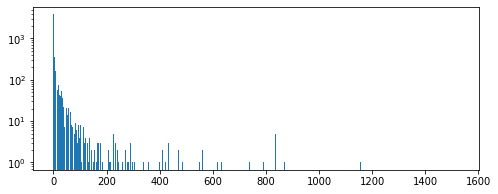

In [412]:
# plot distr
f, ax = plt.subplots(figsize=(8,3))
x, y = np.unique(correct_ranks, return_counts=True)
ax.bar(x, y)
ax.set_yscale('log')

### Compute avg probab of "true" class

In [405]:
correct_probs = []
for ix, cls_distr in ix2cls_distr.items():
    correct_probs.append(ix2cls_distr[ix][ix2label[ix]])
np.mean(correct_probs)

0.2807958

<BarContainer object of 100 artists>

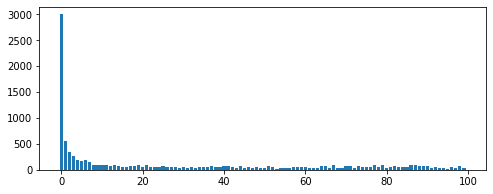

In [414]:
# plot distr
f, ax = plt.subplots(figsize=(8,3))
x, y = np.unique([int(100*p) for p in correct_probs], return_counts=True)
ax.bar(x, y)